In [88]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import weatherbench2 as wb
import metpy
from metpy.units import units
sys.path.append('/users/mfeldman/code/xarray_parcel/')
import modules.parcel_functions as parcel
parcel.load_moist_adiabat_lookups()
print('modules loaded')

modules loaded


In [113]:
hres='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
pangu='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
datasets=[era5,hres,pangu]

for dataset in datasets[:1]:
    print(dataset)
    xr_dataset=xr.open_zarr(dataset)
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.year.isin([2020]))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([7]))#np.arange(3,10)))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([1]))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([12]))
    print(xr_dataset.time)
    #xr_dataset=xr_dataset.drop_dims("time")
    plevel=xr_dataset.level
    tlevel=xr_dataset.temperature
    qlevel=xr_dataset.specific_humidity
    plevel_dim=np.ones([1,len(plevel),1,1])
    for n1 in range(len(plevel.data)):
        plevel_dim[0,n1,0,0]=plevel[n1]
    plevel_exp=np.ones(tlevel.shape)*plevel_dim
    print(plevel_exp.shape)
    dplevel=metpy.calc.dewpoint_from_specific_humidity(plevel_exp* units('hPa'), tlevel* units('K'), qlevel* units('kg/kg'))#.magnitude
    dplevel.data=dplevel.data.to(units.K).magnitude
    #dpl=dplevel[["time", "level", "latitude", "longitude"]]
    print(plevel.shape,tlevel.shape,qlevel.shape,dplevel.shape)

gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr
<xarray.DataArray 'time' (time: 1)>
array(['2020-07-01T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-07-01T12:00:00
(1, 13, 721, 1440)
(13,) (1, 13, 721, 1440) (1, 13, 721, 1440) (1, 13, 721, 1440)


/tmp/ipykernel_487336/3416637474.py:14: UserWarning: Relative humidity >120%, ensure proper units.
  dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude


begin CAPE computation
(13, 721, 1440) (1, 13, 721, 1440) (1, 13, 721, 1440) (1, 721, 1440) (1, 721, 1440) (1, 721, 1440)


Exception: Cannot infer object returned from running user provided function. Please supply the 'template' kwarg to map_blocks.

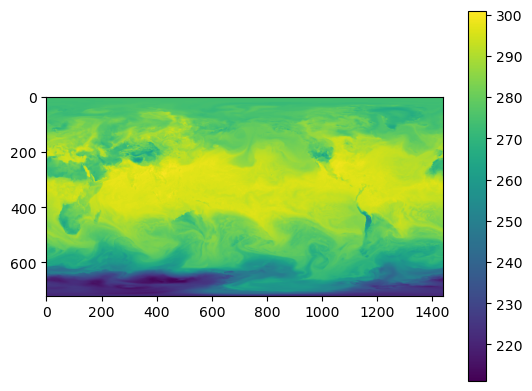

In [116]:
    psurf=xr_dataset.mean_sea_level_pressure
    tsurf=xr_dataset['2m_temperature']
    n1=0
    pid=np.zeros(psurf.shape)
    for lev in plevel:
        n1+=1
        pid[(pid==0) & (psurf<lev*100)]=n1
    qlow=xr_dataset.specific_humidity.isel(level=-1)
    qsurf_interp = xr_dataset.specific_humidity.isel(level=-2) + ( (xr_dataset.specific_humidity.isel(level=-1) - xr_dataset.specific_humidity.isel(level=-2)) \
                                * ((np.log(psurf) - np.log(plevel[-1]*100) ) / ( np.log(plevel[-2]*100) - np.log(plevel[-1]*100) ) ) )

    qsurf = (psurf.data<100000) * qsurf_interp + (psurf.data>=100000) * qsurf

    dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude
    dpsurf.data=dpsurf.data.to(units.K).magnitude
    p=plt.imshow(dpsurf[0,:,:]); plt.colorbar(p)
    #qsurf=xr_dataset.specific_humitidy.interp(level=psurf)
    print('begin CAPE computation')
    print(tlevel.squeeze(dim="time").shape,tlevel.shape,dplevel.shape,tsurf.shape,psurf.shape,dpsurf.shape)
    cape_cin, array = parcel.cape_cin(plevel, tlevel.squeeze(dim="time"), dplevel.squeeze(dim="time"), tsurf.squeeze(dim="time"), psurf.squeeze(dim="time"),
             dpsurf.squeeze(dim="time"), vert_dim='level',template=tsurf.squeeze(dim="time"))


<xarray.DataArray 'mean_sea_level_pressure' (time: 4, latitude: 721,
                                             longitude: 1440)>
dask.array<lt, shape=(4, 721, 1440), dtype=bool, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2020-07-01 ... 2020-07-01T18:00:00
[ 95251.57   95251.85   95256.06  ... 104175.836 104180.62  104191.86 ]


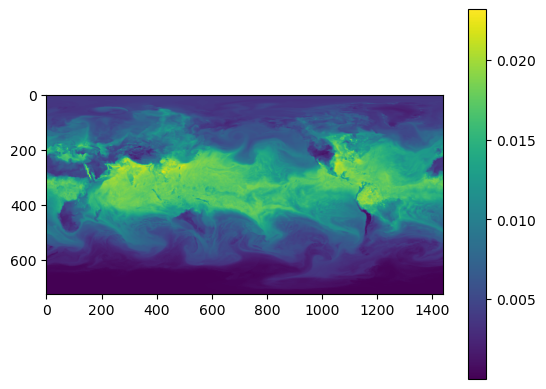

hello


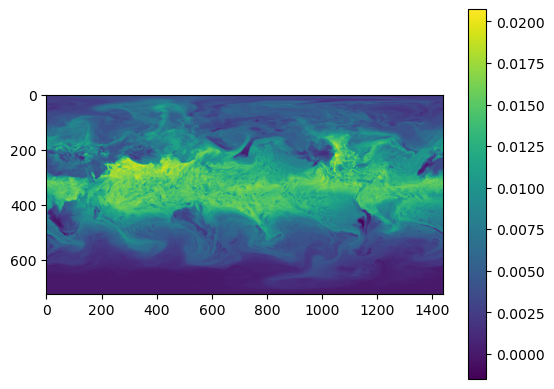

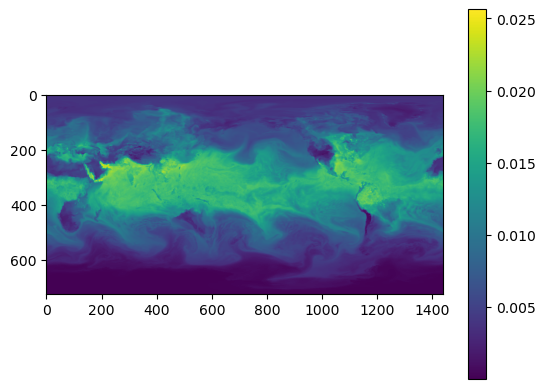

In [69]:
    print(psurf<100000)
    print(np.unique(psurf))
    p=plt.imshow(qsurf[0,:,:]); plt.colorbar(p)
    plt.show()
    print('hello')
    p=plt.imshow(qsurf_interp[0,:,:]); plt.colorbar(p)
    plt.show()
    p=plt.imshow(qlow[0,:,:]); plt.colorbar(p)
    plt.show()

In [74]:

    dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('hPa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude
    dpsurf.data=dpsurf.data.to(units.K).magnitude
    #qsurf=xr_dataset.specific_humitidy.interp(level=psurf)

    cape_cin, array = parcel.cape_cin(plevel, tlevel, dplevel, tsurf, psurf,
             dpsurf, vert_dim='level')

IndentationError: unexpected indent (1734188183.py, line 2)

In [84]:
print(tlevel)

<xarray.DataArray 'temperature' (time: 4, level: 13, latitude: 721,
                                 longitude: 1440)>
dask.array<getitem, shape=(4, 13, 721, 1440), dtype=float32, chunksize=(1, 13, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int64 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2020-07-01 ... 2020-07-01T18:00:00
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K
